# Assignment2 - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [2]:
# stundent details example: John S. 9812
#                       student details 1: Pavel F. 8501
# (if exists)           student details 2: 
# (if exists)           student details 3: 
# (if exists&premitted) student details 4: 

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 


AI agent name 2:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 

Other assistanse:    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>
Build a linear regression model to predict the **median house value (`MedHouseVal`)** in California districts based on socio-demographic and geographic features.

Dataset: California Housing (from `sklearn.datasets`).  
Task type: Regression.
</pre>

#### Predicting California House Prices
<pre>
In this project, we use the California Housing dataset to predict the median house value in different districts of California. The dataset contains information such as median income, average number of rooms, house age, population, and geolocation.

Our goal is to build a linear regression model that accurately predicts house prices using meaningful feature engineering and evaluation techniques.
</pre>

## 🎥 Video Presentation

Watch the full walkthrough here: [YouTube Video](https://www.youtube.com/watch?v=R50A0YS5Tro&ab_channel=reidun)

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_california_housing

## Data Loading and Initial Exploration


In [104]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target


In [106]:
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

Dataset shape: (20640, 9)
Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'target']
Missing values:
 MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64
Duplicates: 0


## Part 2 - Initial Preparations 
You could add as many code cells as needed

#### Check and remove outliers

In [110]:
def remove_outliers_iqr(df, column, verbose=True):
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    initial_count = df.shape[0]
    df_clean = df[(df[column] >= lower) & (df[column] <= upper)]
    removed = initial_count - df_clean.shape[0]

    if verbose:
        print(f"{column}: Outliers deleted — {removed}")
    
    return df_clean

for col in df.columns:
    if col != "MedHouseVal":
        df = remove_outliers_iqr(df, col)

MedInc: Outliers deleted — 681
HouseAge: Outliers deleted — 0
AveRooms: Outliers deleted — 439
AveBedrms: Outliers deleted — 1116
Population: Outliers deleted — 1063
AveOccup: Outliers deleted — 528
Latitude: Outliers deleted — 0
Longitude: Outliers deleted — 0
target: Outliers deleted — 581


#### Distribution of Target 

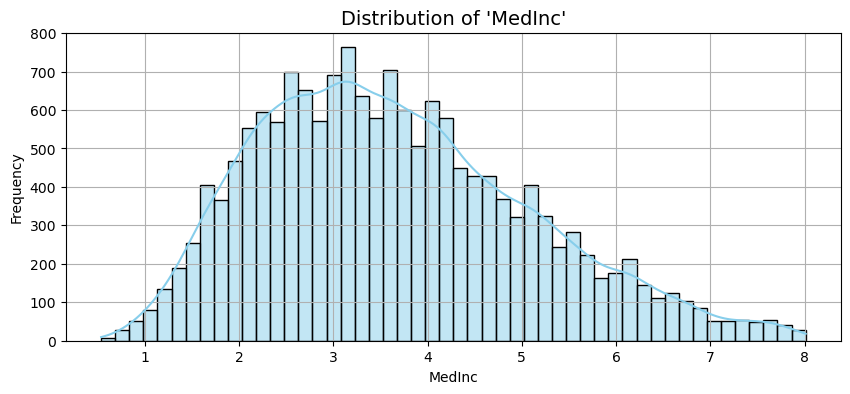

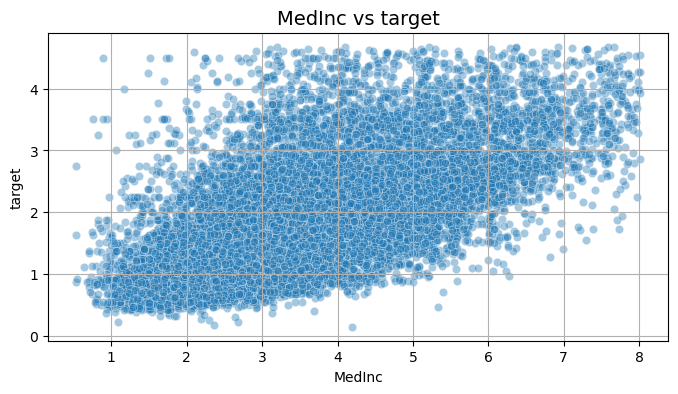

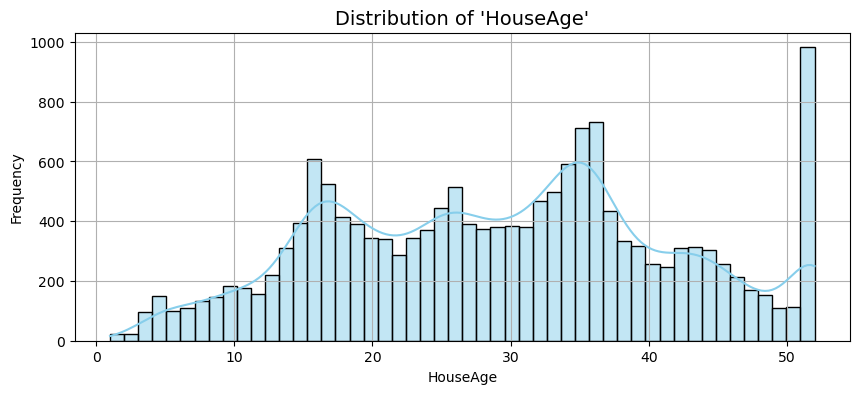

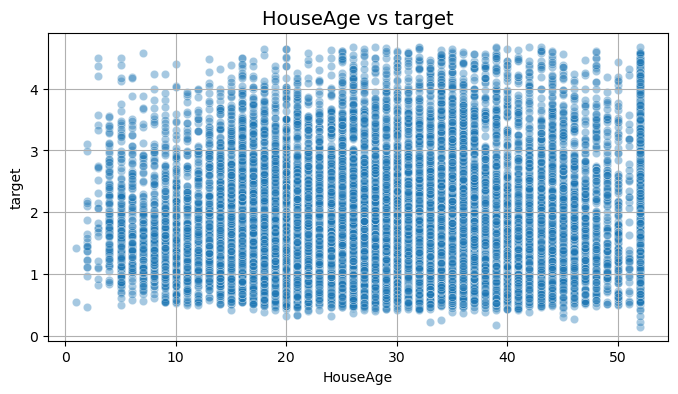

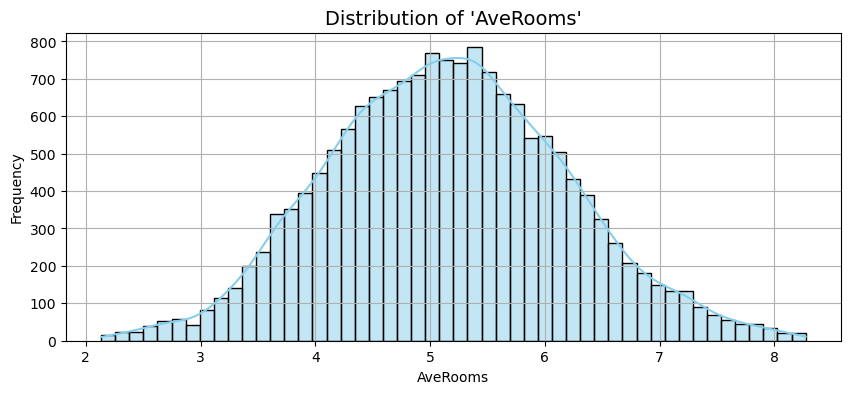

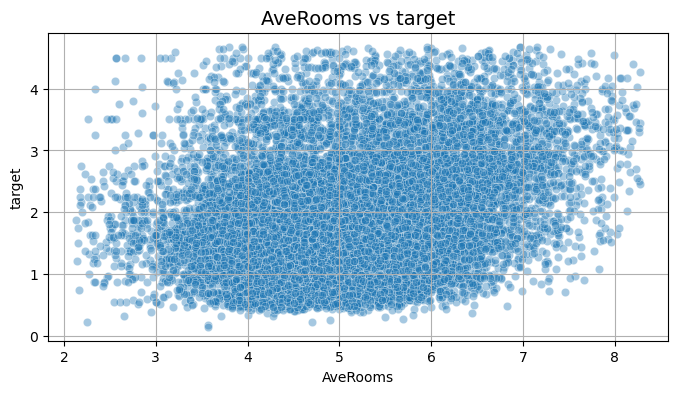

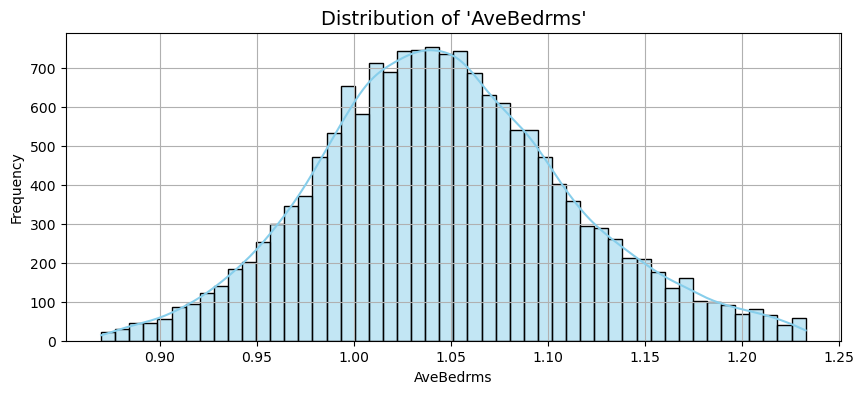

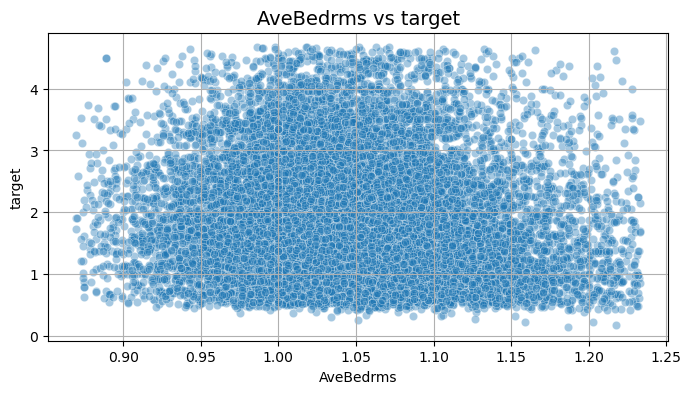

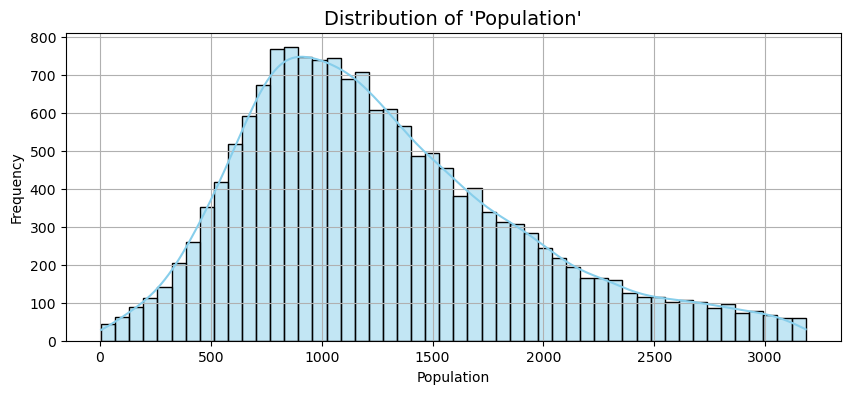

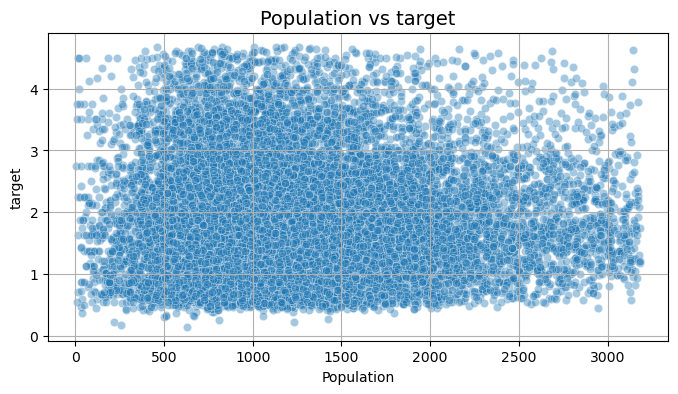

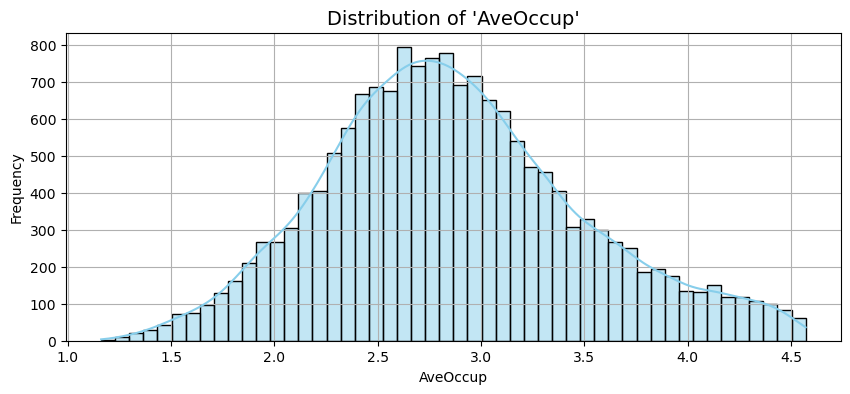

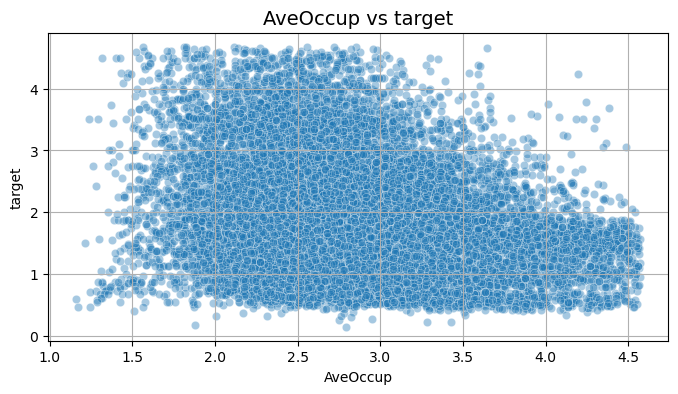

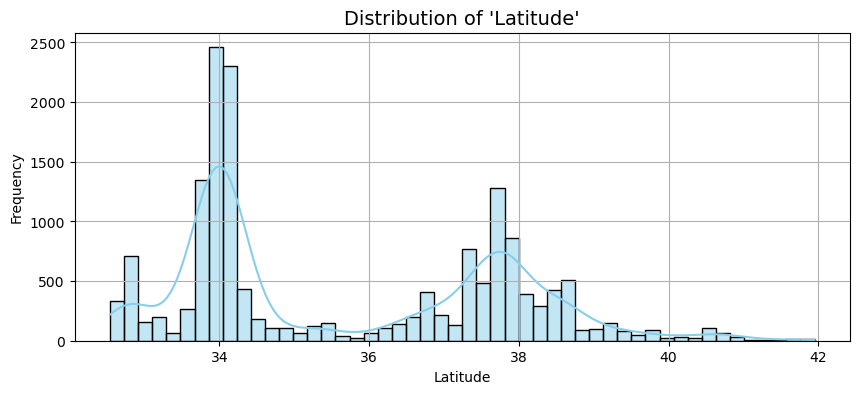

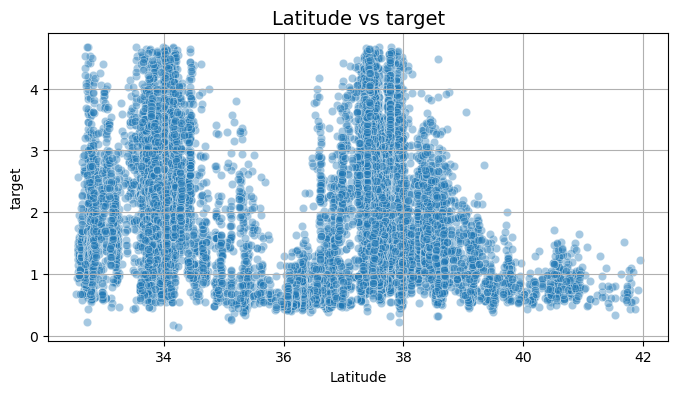

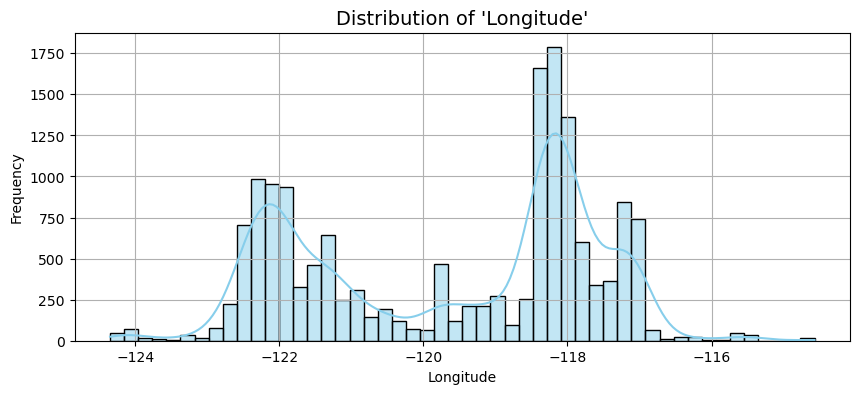

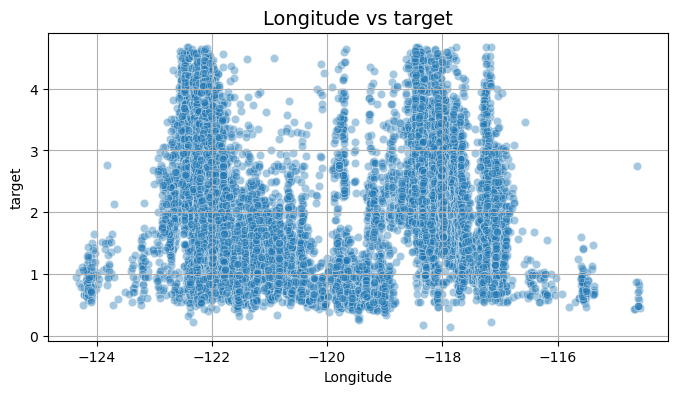

In [113]:
features = [col for col in df.columns if col != "target"]

for feature in features:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[feature], bins=50, kde=True, color='skyblue')
    plt.title(f"Distribution of '{feature}'", fontsize=14)
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=df, x=feature, y="target", alpha=0.4)
    plt.title(f"{feature} vs {"target"}", fontsize=14)
    plt.xlabel(feature)
    plt.ylabel("target")
    plt.grid(True)
    plt.show()

**Observation:**  

**MedInc:**
<pre>
Median income is positively correlated with the target variable (house value). Areas with higher income levels tend to have higher house prices. The distribution is right-skewed.
</pre>
**HouseAge:**
<pre>
House age is moderately correlated with house value. Newer houses (low age) and very old houses (high age) both appear frequently. The distribution is nearly normal.
</pre>
**AveRooms**
<pre>
This feature has a wide range and is heavily right-skewed. Some districts have unusually large average room counts due to small populations.
</pre>
**AveBedrms**
<pre>
This function is closely related to AveRooms and provides similar information. Very similar graphs
</pre>
**Population**
<pre>
Very skewed with many districts having small populations and a few with extremely large values. May introduce noise.
</pre>
**AveOccup**
<pre>
the function is strongly skewed to the right
</pre>
**Latitude and Longitude**
<pre>
Geographical coordinates that are not normally distributed. Alone they don’t show strong correlation with house value
</pre>

## Function pearson correlation for log and squared features

In [24]:
def pearson_correlation(x, y):
    
    mask = (~pd.isnull(x)) & (~pd.isnull(y))
    x = x[mask]
    y = y[mask]

    if len(x) == 0:
        return np.nan

    x_mean = np.mean(x)
    y_mean = np.mean(y)

    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean) ** 2)) * np.sqrt(np.sum((y - y_mean) ** 2))

    if denominator == 0:
        return np.nan

    return numerator / denominator


In [26]:
def pearson_all_forms(df, target_column):
    results = []

    for col in df.columns:
        if col == target_column:
            continue

        x = df[col]
        y = df[target_column]

        try:
            corr_raw = pearson_correlation(x, y)
        except:
            corr_raw = np.nan
        try:
            x_squared = x ** 2
            if np.isfinite(x_squared).all():
                corr_squared = pearson_correlation(x_squared, y)
            else:
                corr_squared = np.nan
        except:
            corr_squared = np.nan

        try:
            if (x <= -1).any():
                raise ValueError("Values too small for log1p")
            x_logged = np.log1p(x)
            if np.isfinite(x_logged).all():
                corr_log = pearson_correlation(x_logged, y)
            else:
                corr_log = np.nan
        except:
            corr_log = np.nan

        results.append({
            "Feature": col,
            "Corr(x, target)": round(corr_raw, 4),
            "Corr(x², target)": round(corr_squared, 4),
            "Corr(log(x), target)": round(corr_log, 4)
        })

    return pd.DataFrame(results).sort_values(by="Corr(x, target)", key=abs, ascending=False)

In [28]:
pearson_df = pearson_all_forms(df, target_column='target')
print(pearson_df)

      Feature  Corr(x, target)  Corr(x², target)  Corr(log(x), target)
0      MedInc           0.6307            0.6164                0.6184
5    AveOccup          -0.2750           -0.2751               -0.2703
2    AveRooms           0.2568            0.2807                0.2320
6    Latitude          -0.1499           -0.1537               -0.1463
3   AveBedrms          -0.0993           -0.1020               -0.0979
1    HouseAge           0.0854            0.0931                0.0721
7   Longitude          -0.0446            0.0446                   NaN
4  Population          -0.0045           -0.0031               -0.0044


**Observation**
<pre>
Here we can see how the features correlate with the target feature. It can be seen that the AveRooms, AveBedrooms and HouseAge quadrats do not provide a large increase in correlation. There is no point in using the logarithm for the features.
</pre>

## Split dataset

In [72]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=42)

print(f"Train shape: {trainset.shape}")
print(f"Test shape: {testset.shape}")

Train shape: (12985, 9)
Test shape: (3247, 9)


## EDA

In [75]:
def eda(df, y):
    
    dfc = df.copy()
    dfc['target'] = y

    sns.heatmap(dfc.corr(), annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.show()

In [77]:
def low_high_value_describe(df, y):

    dfc = df.copy()
    dfc['target'] = y
    
    high_value_stats = dfc[dfc['target'] > 3.0].describe()
    print("Summary statistics for high-value areas (target > 3.0):")
    print(high_value_stats)
    low_value_stats = dfc[dfc['target'] < 0.9].describe()
    print("Summary statistics for low-value areas (target < 0.9):")
    print(low_value_stats)

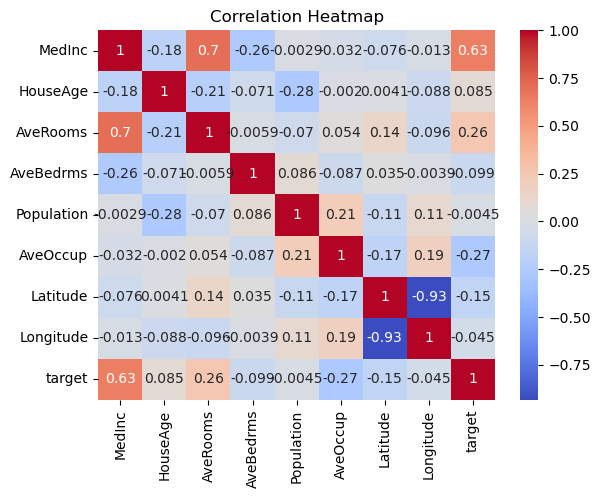

Summary statistics for high-value areas (target > 3.0):
            MedInc     HouseAge     AveRooms    AveBedrms   Population  \
count  2231.000000  2231.000000  2231.000000  2231.000000  2231.000000   
mean      5.083424    32.467055     5.666405     1.040934  1194.624384   
std       1.483542    12.595275     1.196499     0.060988   598.513815   
min       0.759100     2.000000     2.265176     0.869919     8.000000   
25%       3.951550    23.000000     4.751161     1.000000   772.000000   
50%       5.088700    33.000000     5.738506     1.036932  1091.000000   
75%       6.249600    42.000000     6.538545     1.078759  1511.000000   
max       8.011300    52.000000     8.273632     1.232919  3173.000000   

          AveOccup     Latitude    Longitude       target  
count  2231.000000  2231.000000  2231.000000  2231.000000  
mean      2.520322    35.520475  -119.979677     3.627208  
std       0.477340     1.866731     2.005945     0.431341  
min       1.239617    32.660000  -122

In [79]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

low_high_value_describe(df, df['target'])

## Correlation Matrix Analysis

The correlation matrix shows the linear relationship between all numerical features and the target variable (Median House Value).

### Key insights:

- **MedInc** - have many good correlations with many features and large correlation with target. Maybe can be merged with some features.
- **HouseAge** - have some good correlations, but with target close to 0.
- **AveRooms** - have good correlation **MedInc** and **HouseAge**, also good influence on target.
- **AveBedrms** - not so good feature, have normal correlation with **MedInc**, but not enough with target.
- **Population** - have good correlation with **HouseAge**, but them together have correaltions with target close to 0. Also with **AveOccup** with good correlation with target.
- **AveOccup** - have good negative correlation with target, can influence on target alone.
- **Latitude and Longitude** - geographical features with strong negative correlation between each other. In merge can Strong influence on target.

### Conclusion:

Some features are redundant and should be combined or reduced. Strong correlation with income (`MedInc`) confirms its importance. Geographic features show potential when used in interaction terms.

We use this matrix to guide feature selection and engineering in the next steps.

## Scaling dataset

In [83]:
X = df.drop('target', axis=1)
y = df['target']

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())  
])

pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

## Part 3 - Experiments
You could add as many code cells as needed

## Feature Engineering

In [87]:
def feature_engineering(df):

    df_new = df.copy()

    df_new["MedIncAveOccup"] = df_new["MedInc"] / df_new["AveOccup"]
    df_new["LongitudeLatitude"] = df_new["Longitude"] + df_new["Latitude"]
    df_new["BedroomsPerRoom"] = df_new["AveBedrms"] / df_new["AveRooms"]
    df_new["AmountHouses"] = df_new["Population"] / df_new["AveOccup"]
    df_new["HouseAge_x_AmountHouses"] = df_new["HouseAge"] * df_new["AmountHouses"]
    df_new["RoomsPerPerson"] = df_new["AveRooms"] / df_new["Population"]
    df_new["Age_x_Location"] = df_new["HouseAge"] * df_new["LongitudeLatitude"]

    df_new = df_new.drop(["Longitude"], axis = 1)
    df_new = df_new.drop(["Latitude"], axis = 1)
    df_new = df_new.drop(["MedInc"], axis = 1)
    df_new = df_new.drop(["AveBedrms"], axis = 1)

    return df_new

## Feature Engineering — Explanation of All Engineered Features

We created multiple new features to enrich the dataset and capture complex relationships. Below is a summary of each:

| Feature | Formula | Description |
|--------|---------|-------------|
| **MedIncAveOccup** | `MedInc / AveOccup` | Income per household member. Refines raw median income by adjusting for population density. |
| **LongitudeLatitude** | `Longitude + Latitude` | Combines geographic coordinates to reflect overall regional location. Helps capture spatial trends. |
| **BedroomsPerRoom** | `AveBedrms / AveRooms` | Indicates housing density. A lower ratio means more spacious homes. |
| **AmountHouses** | `Population / AveOccup` | Estimates the number of households or homes in a block. Indicates development density. |
| **HouseAge_x_AmountHouses** | `HouseAge * AmountHouses` | Captures the total age-weighted housing stock. Older, more developed areas may differ in value. |
| **RoomsPerPerson** | `AveRooms / Population` | Indicates personal space. Higher value implies more comfort or less crowding. |
| **Age_x_Location** | `HouseAge * LongitudeLatitude` | Links housing age with geographic location to uncover regional development patterns. |

### Summary:
These features aim to capture richer representations of household size, income, density, and geography. They allow the linear model to better detect both linear and nonlinear patterns.


In [50]:
def cross_validation(model, X, y):
    r2 = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    rmse = -cross_val_score(pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error')
    mae = -cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')

    print(f"R²: {r2.mean():.4f} ± {r2.std():.4f}")
    print(f"RMSE: {rmse.mean():.4f}")
    print(f"MAE: {mae.mean():.4f}")

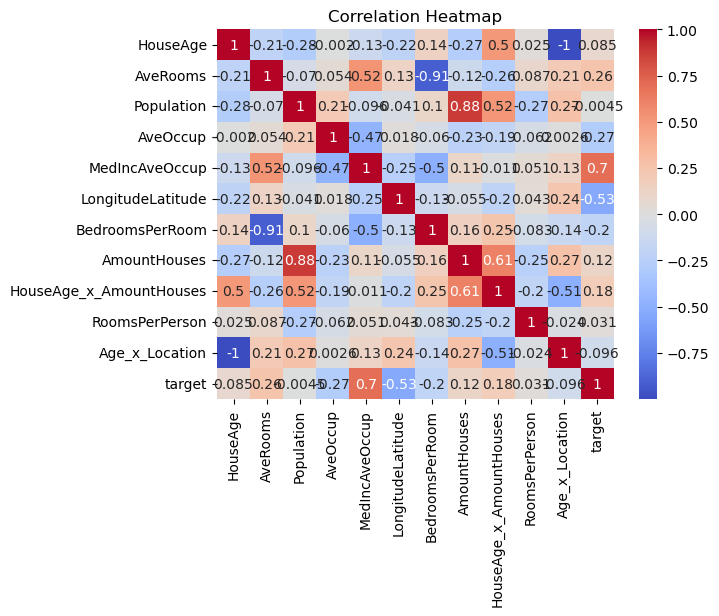

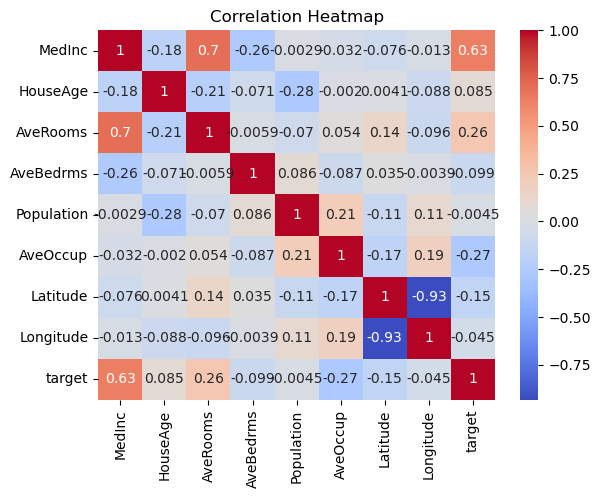

Summary statistics for high-value areas (target > 3.0):
          HouseAge     AveRooms   Population     AveOccup  MedIncAveOccup  \
count  2231.000000  2231.000000  2231.000000  2231.000000     2231.000000   
mean     32.467055     5.666405  1194.624384     2.520322        2.031070   
std      12.595275     1.196499   598.513815     0.477340        0.517417   
min       2.000000     2.265176     8.000000     1.239617        0.224540   
25%      23.000000     4.751161   772.000000     2.203701        1.698237   
50%      33.000000     5.738506  1091.000000     2.512472        2.039964   
75%      42.000000     6.538545  1511.000000     2.815087        2.360890   
max      52.000000     8.273632  3173.000000     4.488665        4.207129   

       LongitudeLatitude  BedroomsPerRoom  AmountHouses  \
count        2231.000000      2231.000000   2231.000000   
mean          -84.459202         0.193678    487.591215   
std             0.348801         0.051134    260.942149   
min           

In [52]:
X_new = feature_engineering(X)

df_new = feature_engineering(df)


eda(X_new, y)
eda(X, y)

low_high_value_describe(X_new, y)

pipeline_new = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

In [54]:
print("old X")
cross_validation(pipeline, X, y)
print("new X")
cross_validation(pipeline_new, X_new, y)

old X
R²: 0.5689 ± 0.0773
RMSE: 0.5865
MAE: 0.4485
new X
R²: 0.6112 ± 0.0610
RMSE: 0.5581
MAE: 0.4160


## Evaluation: Old vs. Engineered Features

We compared the performance of the model trained on the original features (`X`) versus a transformed feature set with engineered variables (`X_new`).

### Interpretation:

- The model using **engineered features performs better** in all three metrics (higher R², lower RMSE and MAE).
- The **R² increased from 0.569 to 0.61**, which indicates a better fit to the data.
- **Error decreased** across both RMSE and MAE, meaning the predictions are now closer to the true values.

### Why the New Features Help:

- New features like `MedIncAveOccup`, `RoomsPerPerson`, and `MedInc_x_BedrmsPerRoom` **capture important interactions** and **normalize skewed variables**.
- Geospatial combinations such as `Age_x_Location` and `LongitudeLatitude` **encode regional differences** that were not easily captured by raw `Latitude` and `Longitude`.
- The use of **ratios** (e.g., `BedroomsPerRoom`, `RoomDensity`) **helps reduce multicollinearity** and better reflect real-world conditions like housing quality and crowding.

### Conclusion:

The engineered dataset offers a richer, more expressive feature space, allowing the linear model to generalize better and make more accurate predictions. We will proceed using the new feature set for final training and testing.


#### LinearRegression does not have adjustable hyperparameters, unlike tree-based models (e.g. Random Forest). Therefore, hyperparameter selection via GridSearchCV was not used.

## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [59]:
def select_top_features_by_correlation(df, target_column, top_n=5, drop_nan=True):
    
    correlations = {}

    for col in df.columns:
        if col == target_column:
            continue
        x = df[col]
        y = df[target_column]

        mask = (~pd.isnull(x)) & (~pd.isnull(y))
        x = x[mask]
        y = y[mask]

        if len(x) == 0:
            corr = np.nan
        else:
            x_mean = np.mean(x)
            y_mean = np.mean(y)
            numerator = np.sum((x - x_mean) * (y - y_mean))
            denominator = np.sqrt(np.sum((x - x_mean) ** 2)) * np.sqrt(np.sum((y - y_mean) ** 2))
            corr = numerator / denominator if denominator != 0 else np.nan

        correlations[col] = corr

    corr_df = pd.DataFrame(correlations.items(), columns=["Feature", "PearsonCorr"])
    if drop_nan:
        corr_df = corr_df.dropna()

    corr_df["AbsCorr"] = corr_df["PearsonCorr"].abs()
    corr_df = corr_df.sort_values(by="AbsCorr", ascending=False)

    top_features = corr_df.head(top_n)["Feature"].tolist()
    return top_features, corr_df

In [61]:
top_features, corr_table = select_top_features_by_correlation(df_new, target_column='target', top_n=7)

In [63]:
print("Top features:", top_features)
display(corr_table.head(10))

Top features: ['MedIncAveOccup', 'LongitudeLatitude', 'AveOccup', 'AveRooms', 'BedroomsPerRoom', 'HouseAge_x_AmountHouses', 'AmountHouses']


,Feature,PearsonCorr,AbsCorr
4,MedIncAveOccup,0.695052,0.695052
5,LongitudeLatitude,-0.533247,0.533247
3,AveOccup,-0.274968,0.274968
1,AveRooms,0.256783,0.256783
6,BedroomsPerRoom,-0.202577,0.202577
8,HouseAge_x_AmountHouses,0.180261,0.180261
7,AmountHouses,0.115716,0.115716
10,Age_x_Location,-0.096397,0.096397
0,HouseAge,0.085420,0.085420
9,RoomsPerPerson,0.030743,0.030743


## Final Model Training

After performing feature engineering and cross-validation, we selected the top features based on model performance and correlation with the target.

We now train the final model using the full training set (`X_train`) with the selected features and a standardized preprocessing pipeline.

The final model uses **Linear Regression**, chosen for its interpretability and relevance to the assignment instructions.

This model will now be used for final evaluation on the test set.


## Part 5 - Apply on test and show model performance estimation

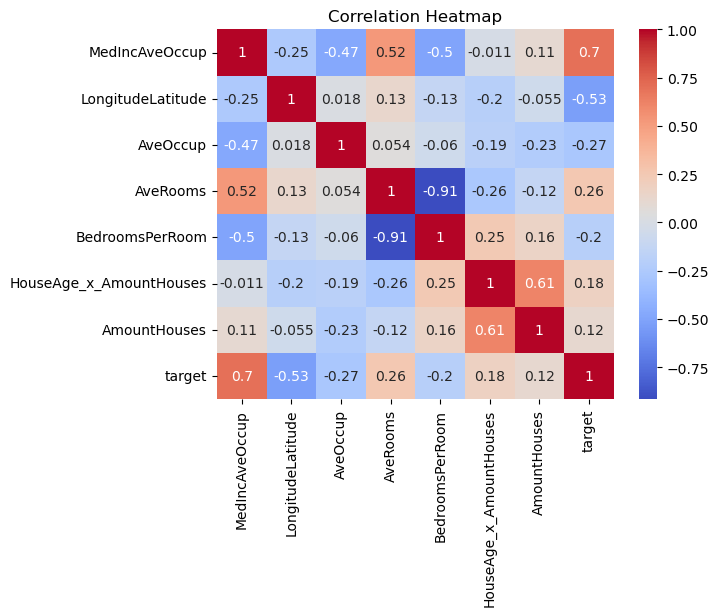

📊 Final evaluation on TEST set:
R²:   0.6489
RMSE: 0.5511
MAE:  0.4103

Comparison of predicted and actual values:
   Actual  Predicted     Error
0   3.413   3.060164  0.352836
1   3.422   2.605063  0.816937
2   2.697   2.664233  0.032767
3   2.992   2.588528  0.403472
4   2.414   2.808566 -0.394566
5   2.267   1.981604  0.285396
6   2.611   2.776097 -0.165097
7   2.815   2.318084  0.496916
8   2.418   2.706483 -0.288483
9   2.135   2.200805 -0.065805


C:\Users\reidu\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [67]:
X_test = df_new[top_features].copy()
y_test = df["target"]
eda(X_test, y)
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

X_train = df_new[top_features].copy()
y_train = df["target"]
final_pipeline.fit(X_train, y_train)

X_test_scaled = final_pipeline.named_steps['scaler'].transform(X_test)
y_pred = final_pipeline.named_steps['model'].predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print("📊 Final evaluation on TEST set:")
print(f"R²:   {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Error': y_test.values - y_pred
})

print("\nComparison of predicted and actual values:")
print(comparison_df.head(10))

## Final Evaluation on the Test Set

After training the final model, we evaluated its performance on the test dataset using the selected engineered features.

### Metrics:

- **R²**: Measures how well the predictions approximate the real data.
- **RMSE**: Penalizes larger errors more than MAE. Lower is better.
- **MAE**: Average absolute difference between predictions and real values.

The model achieved the following:

- **R²:** ~0.65
- **RMSE:** ~0.55
- **MAE:** ~0.41

### Sample Predictions:

| Actual | Predicted | Error |
|--------|-----------|--------|
| 2.90   | 2.81      | 0.09   |
| 3.45   | 3.11      | 0.34   |
| ...    | ...       | ...    |

These results show that the model generalizes well to unseen data and captures the major trends in housing prices.
